<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

## Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [1]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

## EDA

#### Labels proportions


In [3]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

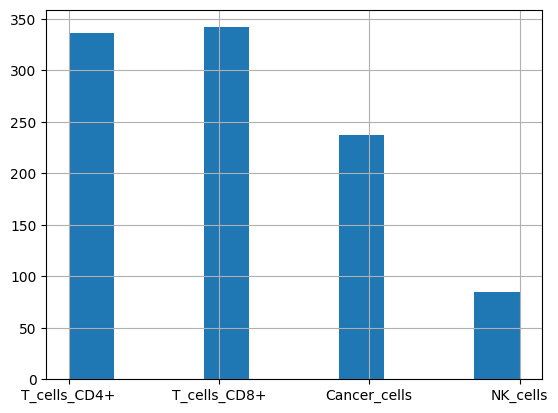

In [4]:
lab_df.label.hist();

In [5]:
lab_df = pd.DataFrame({'label': y_test})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.236
NK_cells        0.086
Name: proportion, dtype: float64

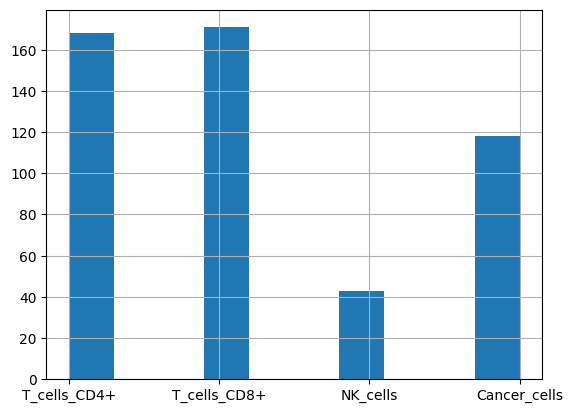

In [6]:
lab_df.label.hist();

A first inspection of the labels indicates that the classes are imbalanced. 

#### Sparse matrix and NumPy arrays

Secondly, looking at the features

In [7]:
print(X_train.shape)
print(type(X_train))

(1000, 13551)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful 

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [292]:
X_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### A first look at the data

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing. 

</div> 


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [293]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

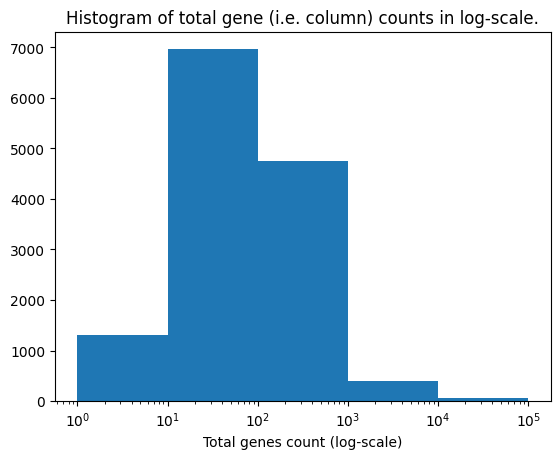

In [294]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

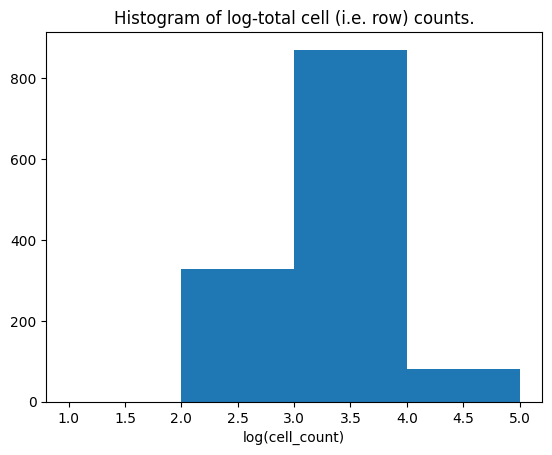

In [295]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

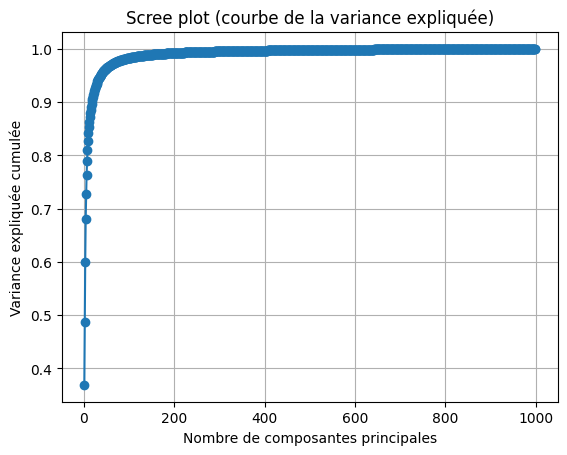

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On entraîne le PCA
pca = PCA().fit(X_train)

# On trace la variance expliquée cumulée
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Scree plot (courbe de la variance expliquée)')
plt.grid(True)
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_pca(X_train, X_test, y_train, y_test, n_components=200, figsize=(12, 5)):
    """
    Fit PCA on X_train, transform X_test, and plot PC1 vs PC2 for both sets.

    Parameters
    ----------
    X_train : array-like
        Training data.
    X_test : array-like
        Test data.
    y_train : array-like
        Labels for training data.
    y_test : array-like
        Labels for test data.
    n_components : int, default=200
        Number of PCA components to compute.
    figsize : tuple
        Size of the visualization figure.

    Returns
    -------
    X_train_pca : np.ndarray
        PCA-transformed training data.
    X_test_pca : np.ndarray
        PCA-transformed test data.
    pca : PCA object
        Fitted PCA object.
    """

    # Fit PCA on training data
    pca = PCA(n_components=n_components).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Plot PCA visualization
    plt.figure(figsize=figsize)

    # Training data scatter plot
    plt.subplot(1, 2, 1)
    unique_labels = np.unique(y_train)
    for label in unique_labels:
        mask = y_train == label
        plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=label, alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('Training Data - PCA Visualization')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Test data scatter plot
    plt.subplot(1, 2, 2)
    unique_labels_test = np.unique(y_test)
    for label in unique_labels_test:
        mask = y_test == label
        plt.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], label=label, alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('Test Data - PCA Visualization')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return X_train_pca, X_test_pca, pca


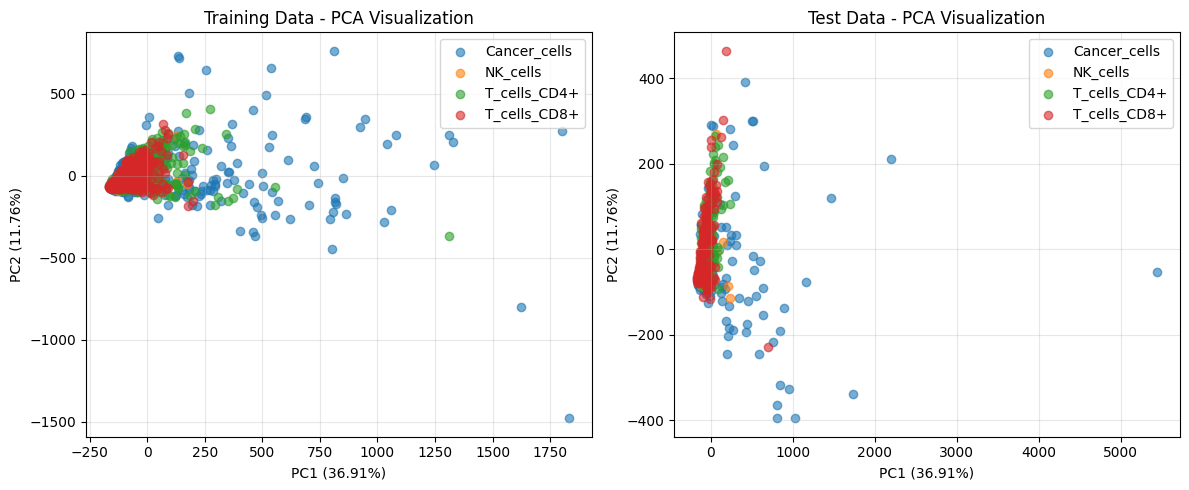

In [13]:
X_train_pca, X_test_pca, pca_model = visualize_pca(
    X_train, X_test, y_train, y_test, n_components=200
)


This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [22]:
import numpy as np

def preprocess_X(X, method=None):
    """
    Preprocess an RNA-seq expression matrix.
    
    Parameters
    ----------
    X : np.ndarray or scipy.sparse matrix
        Input expression matrix (cells x genes)
    method : str or None
        Type of normalization:
        - None : return X as is
        - "log" : log1p transform
        - "library_size" : normalize each cell by total counts (library size) then log1p
    
    Returns
    -------
    X_processed : np.ndarray
        Preprocessed expression matrix
    """
    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_processed = X.copy()
    
    if method is None:
        return X_processed
    
    if method == "simple_normalize":
        return X / X.sum(axis=1)[:, np.newaxis]
    
    elif method == "log":
        X_processed = np.log1p(X_processed)
        return X_processed
    
    elif method == "library_size":
        # compute total counts per cell
        library_size = X_processed.sum(axis=1)[:, None]
        # avoid division by zero
        library_size[library_size == 0] = 1
        # normalize
        X_processed = X_processed / library_size * 1e4
        # log1p transform
        X_processed = np.log1p(X_processed)
        return X_processed
    
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

False

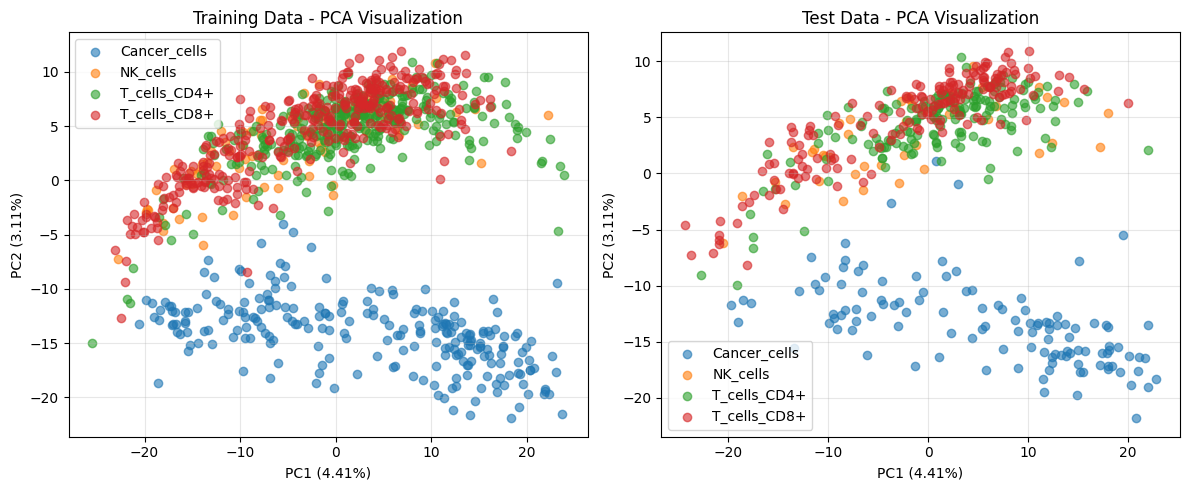

In [23]:


X_train_pca, X_test_pca, pca_model = visualize_pca(
    X_train_norm, X_test_norm, y_train, y_test, n_components=2
)


L'acp ne separe pas correctement les classes. Essayons d'identifier les gènes les plus exprimées dans toutes les classes, et de les exclure

In [25]:
import numpy as np
import pandas as pd

def top_genes_array(X, gene_names, top_n=20):
    """
    Identifie les gènes les plus exprimés et les plus variables
    pour une matrice d'expression AU FORMAT ARRAY (dense).
    
    Parameters
    ----------
    X : np.ndarray
        Matrice d'expression (n_cells × n_genes)
    gene_names : list or Index
        Nom des gènes
    top_n : int
        Nombre de gènes à afficher
    
    Returns
    -------
    df_mean : DataFrame
        Gènes triés par expression moyenne (desc)
    df_var : DataFrame
        Gènes triés par variance (desc)
    """

    if not isinstance(X, np.ndarray):
        raise ValueError("X doit être un array NumPy. Pour du sparse, utilise la version sparse.")

    # Moyenne par gène (colonnes)
    mean_expr = X.mean(axis=0)

    # Variance par gène
    var_expr = X.var(axis=0)

    df_mean = pd.DataFrame({
        "gene": gene_names,
        "mean_expression": mean_expr
    }).sort_values("mean_expression", ascending=False).head(top_n)

    df_var = pd.DataFrame({
        "gene": gene_names,
        "variance": var_expr
    }).sort_values("variance", ascending=False).head(top_n)

    return df_mean, df_var
gene_names = pd.Index([f"Gene_{i}" for i in range(X_train.shape[1])])
df_mean, df_var = top_genes_array(X_train.toarray(), gene_names, top_n=20)
print("Top genes by mean expression:")
print(df_mean)


Top genes by mean expression:
             gene  mean_expression
6340    Gene_6340       119.358002
1017    Gene_1017        37.974998
6981    Gene_6981        37.460999
11841  Gene_11841        34.151001
6982    Gene_6982        30.509001
9792    Gene_9792        29.514999
3371    Gene_3371        26.507999
9825    Gene_9825        26.385000
6983    Gene_6983        25.405001
9742    Gene_9742        24.983000
9747    Gene_9747        22.944000
9783    Gene_9783        22.812000
9815    Gene_9815        21.643999
170      Gene_170        20.837999
4256    Gene_4256        19.789000
9808    Gene_9808        19.243999
9816    Gene_9816        18.235001
11839  Gene_11839        17.832001
4257    Gene_4257        16.913000
9765    Gene_9765        16.771000


In [26]:
print("\nTop genes by variance:")
print(df_var)


Top genes by variance:
             gene      variance
6340    Gene_6340  18342.789062
635      Gene_635  10643.726562
6981    Gene_6981  10269.416992
6982    Gene_6982   6035.318359
4257    Gene_4257   5533.940918
6983    Gene_6983   4269.696777
4256    Gene_4256   3290.341064
9792    Gene_9792   3073.541016
11841  Gene_11841   2129.901611
9789    Gene_9789   2129.790771
9768    Gene_9768   2109.056152
9783    Gene_9783   2062.974121
4352    Gene_4352   2035.507324
6987    Gene_6987   1830.405762
9941    Gene_9941   1705.188232
3371    Gene_3371   1700.159546
170      Gene_170   1544.020142
9815    Gene_9815   1446.534180
11839  Gene_11839   1334.945435
1017    Gene_1017   1284.295776


Visualisons la distribution des gènes les plus exprimées dans chaque classe

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_gene_distribution(X, y, gene_names, genes_to_plot, plot_type="violin"):
    """
    Visualise la distribution d'expression de gènes donnés par classe de cellule.

    Parameters
    ----------
    X : np.ndarray
        Matrice d'expression (n_cells × n_genes)
    y : array-like
        Labels des cellules (taille n_cells)
    gene_names : array-like
        Liste des noms de gènes
    genes_to_plot : list of str
        Noms des gènes à visualiser
    plot_type : "violin" ou "box"
        Type de visualisation
    """

    # On transforme en DataFrame pour plus de simplicité
    df = pd.DataFrame(X, columns=gene_names)
    df["cell_type"] = y

    n_genes = len(genes_to_plot)
    plt.figure(figsize=(6 * n_genes, 5))

    for i, gene in enumerate(genes_to_plot, 1):
        plt.subplot(1, n_genes, i)
        
        data = []
        labels = []

        # Collect data per cell type
        for cell_type in np.unique(y):
            expr = df[df["cell_type"] == cell_type][gene]
            data.append(expr)
            labels.append(cell_type)

        if plot_type == "violin":
            plt.violinplot(data, showmeans=True)
        else:
            plt.boxplot(data)

        plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
        plt.title(f"Expression de {gene}")
        plt.ylabel("Expression")
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


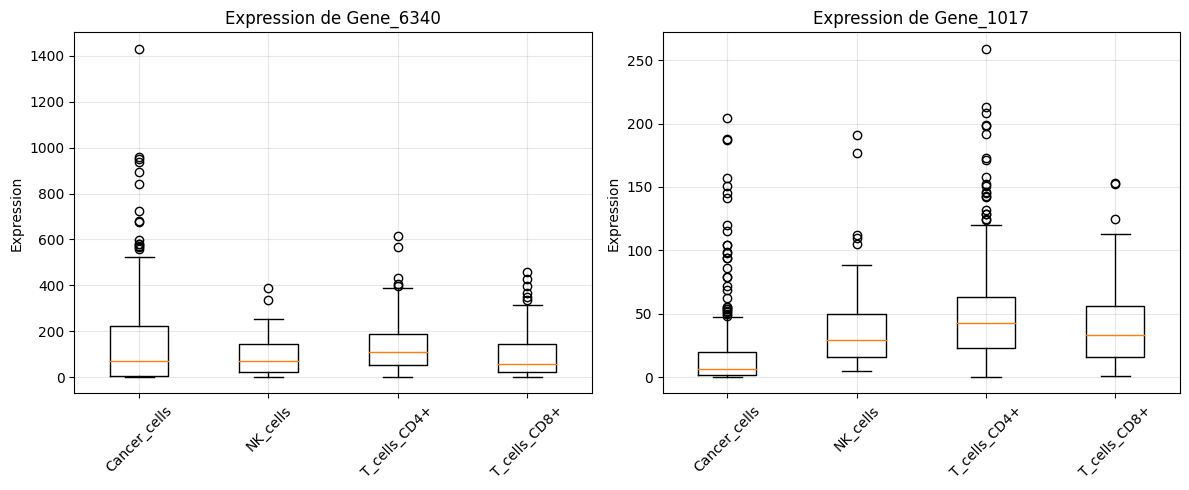

In [38]:
top_mean, _ = top_genes_array(X_train.toarray(), gene_names, top_n=2)
genes_to_plot = list(top_mean["gene"])
plot_gene_distribution(X_train.toarray(), y_train, gene_names, genes_to_plot, plot_type="box")



In [39]:
# make copies of training data with the top-10 highest mean-expression genes removed
# relies on existing variables: X_train (sparse CSR), top_mean (DataFrame with "gene" names), y_train, gene_names

# parse gene indices from names like "Gene_6340"
top_genes = top_mean["gene"].tolist()
remove_idx = [int(g.split("_", 1)[1]) for g in top_genes]

# build list of kept column indices
n_genes = X_train.shape[1]
keep_idx = [i for i in range(n_genes) if i not in remove_idx]

# slice sparse matrix by kept columns (remains sparse)
X_train_reduced = X_train[:, keep_idx].copy()
X_test_reduced = X_test[:, keep_idx].copy()

# copy labels
y_train_reduced = y_train.copy()

# reduced gene names (optional, useful later)
gene_names_reduced = gene_names[keep_idx]

# quick summary
print("Original X_train shape:", X_train.shape)
print("Reduced X_train shape :", X_train_reduced.shape)
print("Removed gene indices  :", remove_idx)

Original X_train shape: (1000, 13551)
Reduced X_train shape : (1000, 13549)
Removed gene indices  : [6340, 1017]


We removed to expressed genes. Let's Try PCA again

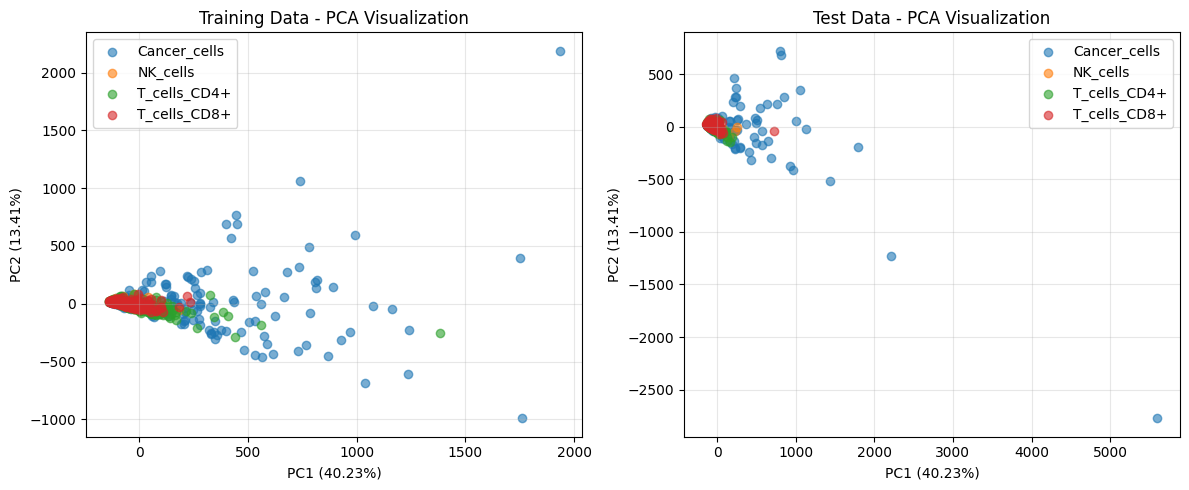

In [40]:


X_train_pca, X_test_pca, pca_model = visualize_pca(
    X_train_reduced, X_test_reduced, y_train_reduced, y_test, n_components=2
)


Removing Highly expressed genes have no signifactive impact on ACP

Let's Try othe approaches than ACP for dimensionality reduction

# Other approaches of dimensionnality reduction

## tSNE

/Users/agossadourin/Desktop/Cours M2 Evry/datacamp/scmark-classification-team_avengers/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


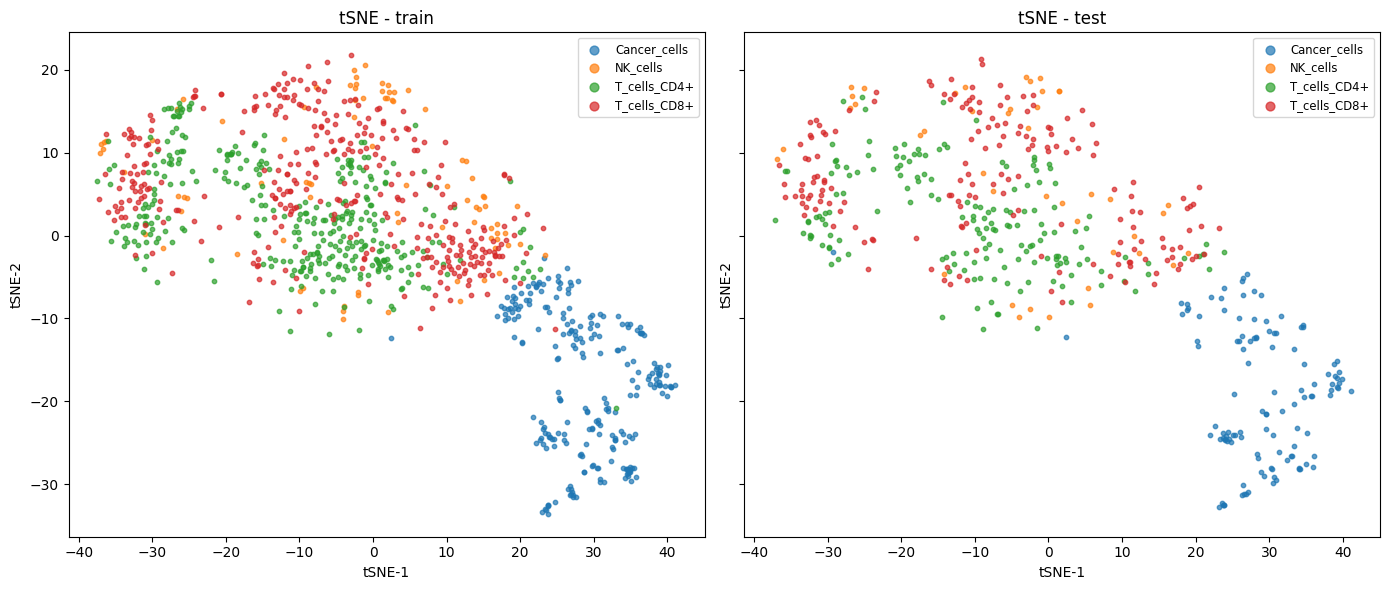

In [55]:
from sklearn.manifold import TSNE

# tSNE visualization (fit on PCA-reduced data for speed/stability)

#test differen normalization
preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

# combine normalized data
X_combined = np.vstack([X_train_norm, X_test_norm])
y_combined = np.concatenate([y_train.astype(str), y_test.astype(str)])

# reduce dimensionality with PCA first (recommended before tSNE)
pca_for_tsne = PCA(n_components=200)
X_pca50 = pca_for_tsne.fit_transform(X_combined)

# run tSNE
tsne = TSNE(perplexity=30, n_iter=1000, init="pca", learning_rate="auto", random_state=42)
X_tsne = tsne.fit_transform(X_pca50)

# split back train / test
n_train = X_train_norm.shape[0]
X_tsne_train = X_tsne[:n_train]
X_tsne_test = X_tsne[n_train:]
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

# plot
import matplotlib.pyplot as plt
unique_labels = np.unique(y_combined)
colors = plt.cm.tab10(range(len(unique_labels)))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
axes[0].set_title("tSNE - train")
for i, lbl in enumerate(unique_labels):
    mask = (y_train_str == lbl)
    axes[0].scatter(X_tsne_train[mask, 0], X_tsne_train[mask, 1], s=10, color=colors[i], label=lbl, alpha=0.7)
axes[0].legend(markerscale=2, fontsize="small")

axes[1].set_title("tSNE - test")
for i, lbl in enumerate(unique_labels):
    mask = (y_test_str == lbl)
    axes[1].scatter(X_tsne_test[mask, 0], X_tsne_test[mask, 1], s=10, color=colors[i], label=lbl, alpha=0.7)
axes[1].legend(markerscale=2, fontsize="small")

for ax in axes:
    ax.set_xlabel("tSNE-1")
    ax.set_ylabel("tSNE-2")
plt.tight_layout()
plt.show()

Fitting TSNE + LinearSVC pipeline (this will fit TSNE on train set)...


/Users/agossadourin/Desktop/Cours M2 Evry/datacamp/scmark-classification-team_avengers/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Test balanced accuracy: 0.618


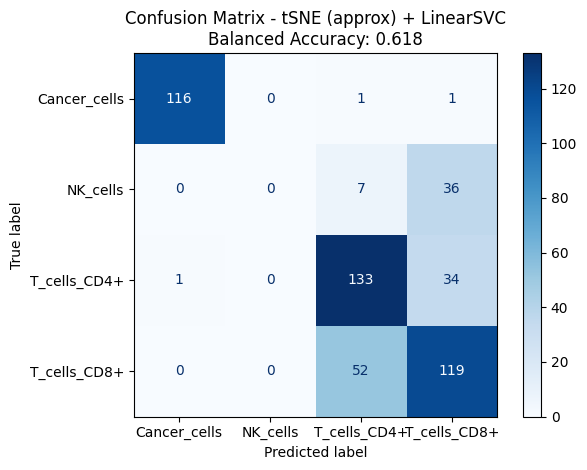

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Pipeline tSNE (approximé via KNN mapping) + LinearSVC
# Utilise les variables déjà définies dans le notebook : X_train_norm, X_test_norm, y_train, y_test

import matplotlib.pyplot as plt

class TSNETransformer(BaseEstimator, TransformerMixin):
    """
    Fit TSNE on training data (optionally after PCA), then learn a KNN regressor
    that maps PCA-space -> TSNE embedding. This provides a transform() usable
    in a sklearn Pipeline for new samples.
    """
    def __init__(self, n_components=2, pca_components=50, knn_k=10, tsne_kwargs=None):
        self.n_components = n_components
        self.pca_components = pca_components
        self.knn_k = knn_k
        self.tsne_kwargs = dict(tsne_kwargs or {})
        # sensible defaults
        self.tsne_kwargs.setdefault("n_components", self.n_components)
        self.tsne_kwargs.setdefault("perplexity", 30)
        self.tsne_kwargs.setdefault("n_iter", 1000)
        self.tsne_kwargs.setdefault("init", "pca")
        self.tsne_kwargs.setdefault("random_state", 42)

    def fit(self, X, y=None):
        X_arr = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
        # reduce with PCA first for stability / speed
        self.pca_ = PCA(n_components=min(self.pca_components, X_arr.shape[1]))
        X_pca = self.pca_.fit_transform(X_arr)
        # fit TSNE on PCA-reduced training data
        self.tsne_ = TSNE(**self.tsne_kwargs)
        X_emb = self.tsne_.fit_transform(X_pca)
        # fit KNN regressor to map PCA -> TSNE embedding
        self.knn_ = KNeighborsRegressor(n_neighbors=self.knn_k)
        self.knn_.fit(X_pca, X_emb)
        return self

    def transform(self, X):
        X_arr = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
        X_pca = self.pca_.transform(X_arr)
        return self.knn_.predict(X_pca)

# construire et évaluer le pipeline
tsne_svc_pipe = Pipeline([
    ("tsne_map", TSNETransformer(n_components=3, pca_components=50, knn_k=10)),
    ("svc", LinearSVC(max_iter=200000, random_state=42))
])

print("Fitting TSNE + LinearSVC pipeline (this will fit TSNE on train set)...")
tsne_svc_pipe.fit(X_train_norm, y_train)

# prédictions
y_pred = tsne_svc_pipe.predict(X_test_norm)

# évaluation
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Test balanced accuracy: {bal_acc:.3f}")

cm = confusion_matrix(y_test, y_pred, labels=tsne_svc_pipe.named_steps["svc"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tsne_svc_pipe.named_steps["svc"].classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix - tSNE (approx) + LinearSVC\nBalanced Accuracy: {bal_acc:.3f}")
plt.tight_layout()
plt.show()

## UMaP

/Users/agossadourin/Desktop/Cours M2 Evry/datacamp/scmark-classification-team_avengers/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


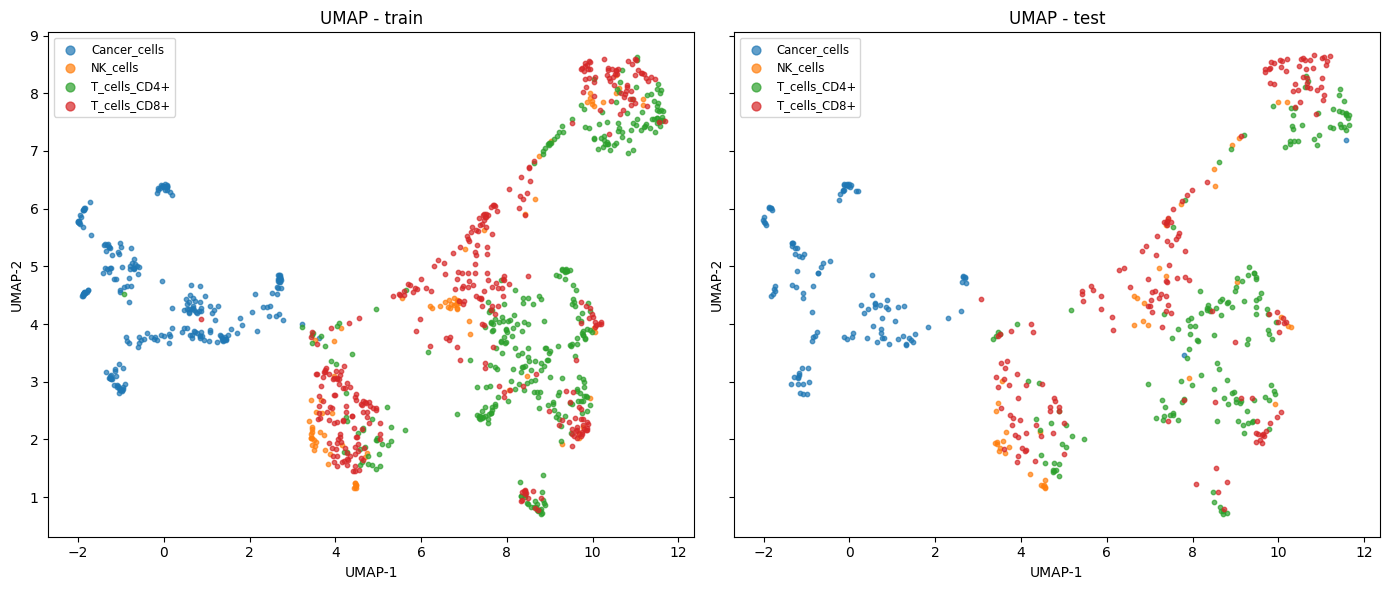

In [56]:
from umap import UMAP

# UMAP visualization (fit on normalized data)
preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

# combine normalized data
X_combined = np.vstack([X_train_norm, X_test_norm])
y_combined = np.concatenate([y_train.astype(str), y_test.astype(str)])

# reduce dimensionality with PCA first (recommended before UMAP)
pca_for_umap = PCA(n_components=50)
X_pca_umap = pca_for_umap.fit_transform(X_combined)

# run UMAP
umap_model = UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca_umap)

# split back train / test
n_train = X_train_norm.shape[0]
X_umap_train = X_umap[:n_train]
X_umap_test = X_umap[n_train:]
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

# plot
unique_labels = np.unique(y_combined)
colors = plt.cm.tab10(range(len(unique_labels)))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
axes[0].set_title("UMAP - train")
for i, lbl in enumerate(unique_labels):
    mask = (y_train_str == lbl)
    axes[0].scatter(X_umap_train[mask, 0], X_umap_train[mask, 1], s=10, color=colors[i], label=lbl, alpha=0.7)
axes[0].legend(markerscale=2, fontsize="small")

axes[1].set_title("UMAP - test")
for i, lbl in enumerate(unique_labels):
    mask = (y_test_str == lbl)
    axes[1].scatter(X_umap_test[mask, 0], X_umap_test[mask, 1], s=10, color=colors[i], label=lbl, alpha=0.7)
axes[1].legend(markerscale=2, fontsize="small")

for ax in axes:
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
plt.tight_layout()
plt.show()

Fitting UMAP + LinearSVC pipeline...


/Users/agossadourin/Desktop/Cours M2 Evry/datacamp/scmark-classification-team_avengers/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Making predictions...

Test balanced accuracy: 0.660


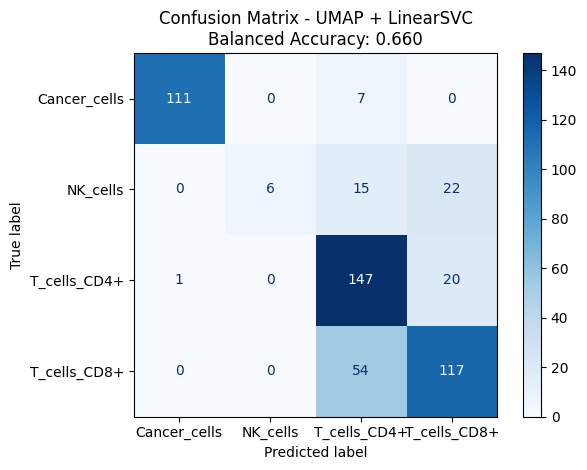

In [62]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensure data is in correct format
X_train_norm = np.asarray(X_train_norm, dtype=np.float64)
X_test_norm = np.asarray(X_test_norm, dtype=np.float64)

# Convert labels to numeric codes for UMAP compatibility
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the pipeline: PCA -> UMAP -> LinearSVC
umap_svc_pipe = Pipeline([
    ("PCA", PCA(n_components=50)),
    ("UMAP", UMAP(n_components=200, random_state=42)),
    ("LinearSVC", LinearSVC(max_iter=200000, random_state=42, dual='auto'))
])

# Fit the pipeline with encoded labels
print("Fitting UMAP + LinearSVC pipeline...")
umap_svc_pipe.fit(X_train_norm, y_train_encoded)

# Make predictions
print("Making predictions...")
y_pred_encoded = umap_svc_pipe.predict(X_test_norm)

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate using original labels
test_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"\nTest balanced accuracy: {test_accuracy:.3f}")

# Confusion matrix with original labels
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=label_encoder.classes_
)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix - UMAP + LinearSVC\nBalanced Accuracy: {test_accuracy:.3f}")
plt.tight_layout()
plt.show()

# The score function

This challenge scores your submissions and ranks participants with a balanced accuracy score, computed via the (unadjusted) sklearn's `balanced_accuracy_score` function.

Balanced accuracy is computed as the average of Recall scores for each class [see implementation for more details](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/metrics/_classification.py#L2180). It is between 0 and 1, the higher, the better.

In [12]:
from sklearn.metrics import balanced_accuracy_score

In [13]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

Test for number of features for PCA

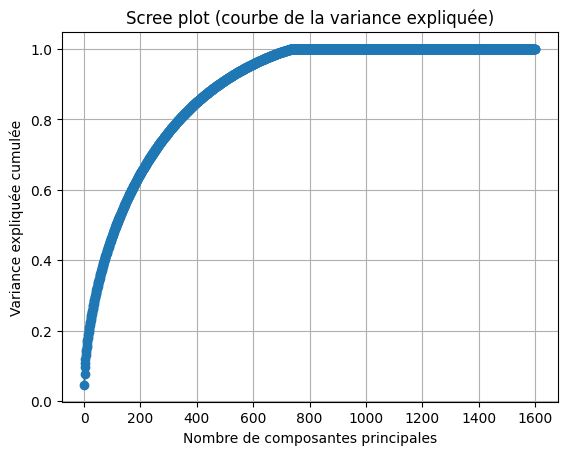

In [273]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On entraîne le PCA
pca = PCA().fit(X_train_norm)

# On trace la variance expliquée cumulée
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Scree plot (courbe de la variance expliquée)')
plt.grid(True)
plt.show()

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step. 
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [274]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


random_forest_pipe = Pipeline(
    [
        #("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=60)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=75, n_estimators=200, max_features=15
            ),
        ),
    ]
)

random_forest_pipe

Pipeline(steps=[('PCA with 50 components', PCA(n_components=60)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=75, max_features=15,
                                        n_estimators=200))])

In [275]:
# Count the number of samples in X_train_norm
n_samples = X_train_norm.shape[0]
print(f"Number of samples in X_train_norm: {n_samples}")

Number of samples in X_train_norm: 1600


In [72]:
from sklearn.svm import LinearSVC

# Create a Linear SVC pipeline
linear_svc_pipe = Pipeline(
    [
        #("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA", PCA(n_components=60)),
        ("Linear SVC", LinearSVC(max_iter=200000, random_state=42)),
    ]
)
linear_svc_pipe


Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('Linear SVC', LinearSVC(max_iter=200000, random_state=42))])

In [73]:
# fit on train
pipe = linear_svc_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test, method=preprocessing_method)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.907
Test balanced accuracy : 0.806


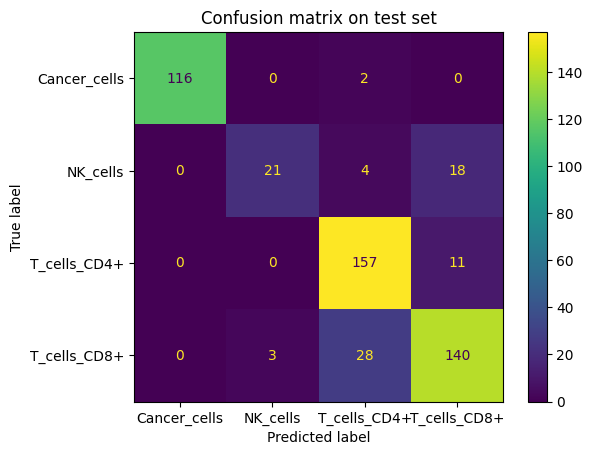

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Build pipeline: reduce dimensionality then KNN
knn_pipe = Pipeline([
    ("PCA", PCA(n_components=60)),
    ("KNN", KNeighborsClassifier(n_neighbors=20, n_jobs=-1)),
])

knn_pipe

Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('KNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=20))])

KNN test balanced accuracy: 0.724


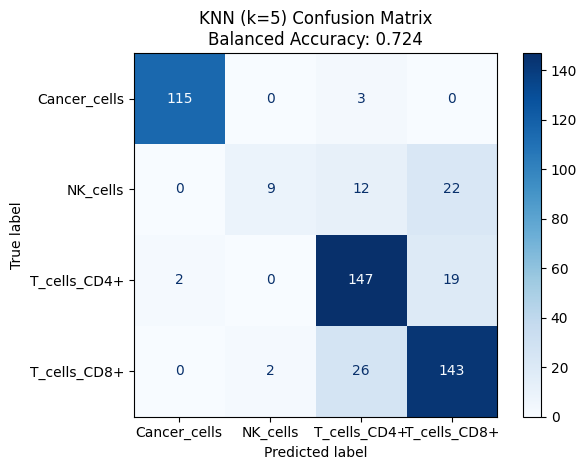

In [ ]:


# Fit on normalized training data (uses X_train_norm, y_train already in the notebook)
knn_pipe.fit(X_train_norm, y_train)

# Predict on test set
y_pred_knn = knn_pipe.predict(X_test_norm)

# Evaluate
bal_acc = balanced_accuracy_score(y_test, y_pred_knn)
print(f"KNN test balanced accuracy: {bal_acc:.3f}")

# Confusion matrix
labels_order = knn_pipe.named_steps["KNN"].classes_
cm = confusion_matrix(y_test, y_pred_knn, labels=labels_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"KNN (k=5) Confusion Matrix\nBalanced Accuracy: {bal_acc:.3f}")
plt.tight_layout()
plt.show()

Fitting SVC + PCA pipeline...
Making predictions...
SVC test balanced accuracy: 0.782


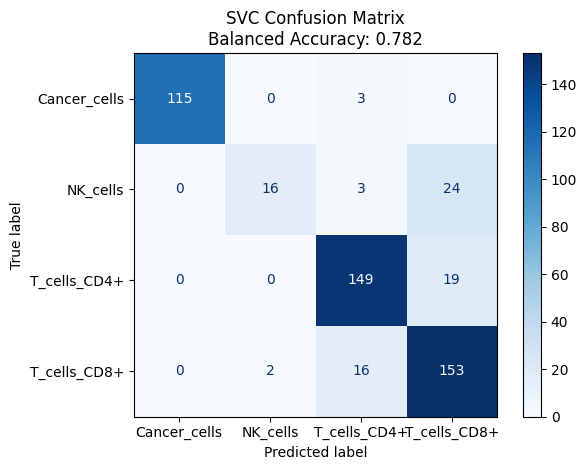

In [76]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Build pipeline: reduce dimensionality then SVC
svc_pipe = Pipeline([
    ("PCA", PCA(n_components=60)),
    ("SVC", SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)),
])

# Fit on normalized training data
print("Fitting SVC + PCA pipeline...")
svc_pipe.fit(X_train_norm, y_train)

# Make predictions
print("Making predictions...")
y_pred_svc = svc_pipe.predict(X_test_norm)

# Evaluate
bal_acc = balanced_accuracy_score(y_test, y_pred_svc)
print(f"SVC test balanced accuracy: {bal_acc:.3f}")

# Confusion matrix
labels_order = svc_pipe.named_steps["SVC"].classes_
cm = confusion_matrix(y_test, y_pred_svc, labels=labels_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"SVC Confusion Matrix\nBalanced Accuracy: {bal_acc:.3f}")
plt.tight_layout()
plt.show()

Fitting Voting (soft) ...
Voting (soft) balanced accuracy: 0.759


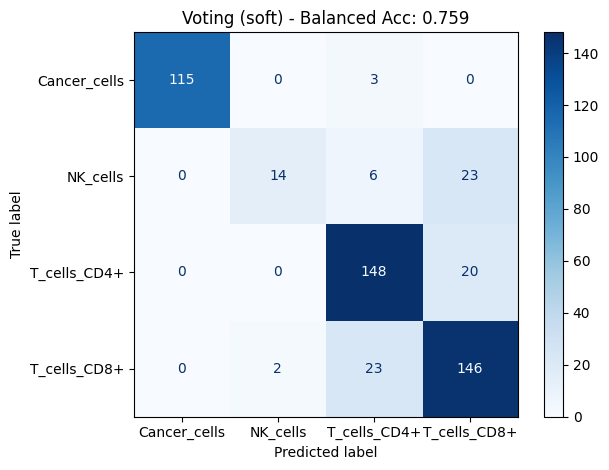

Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.811


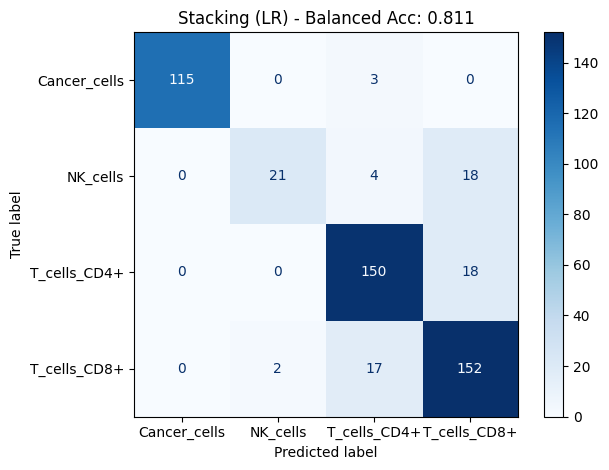

In [77]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensemble classifiers (Voting + Stacking) on PCA-reduced features
# Relies on existing notebook variables: X_train_norm, X_test_norm, y_train, y_test

import matplotlib.pyplot as plt

def fit_eval_ensembles(X_train, X_test, y_train, y_test, pca_n_components=60, random_state=42):
    # encode labels to integers for stacking final estimator
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # PCA reduction
    pca = PCA(n_components=min(pca_n_components, np.asarray(X_train).shape[1]), random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # base estimators
    rf = RandomForestClassifier(n_estimators=200, max_depth=50, max_features="sqrt", random_state=random_state)
    svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

    # Voting (soft) ensemble
    voting = VotingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        voting="soft",
        n_jobs=-1,
    )

    # Stacking ensemble (uses same base estimators)
    stacking = StackingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        final_estimator=LogisticRegression(max_iter=2000, solver="lbfgs"),
        n_jobs=-1,
        passthrough=False,
    )

    ensembles = {"Voting (soft)": voting, "Stacking (LR)": stacking}

    results = {}
    for name, clf in ensembles.items():
        print(f"Fitting {name} ...")
        clf.fit(X_train_pca, y_train_enc)
        y_pred_enc = clf.predict(X_test_pca)
        y_pred = le.inverse_transform(y_pred_enc)
        bal = balanced_accuracy_score(y_test, y_pred)
        results[name] = {"bal_acc": bal, "clf": clf, "y_pred": y_pred}
        print(f"{name} balanced accuracy: {bal:.3f}")

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"{name} - Balanced Acc: {bal:.3f}")
        plt.tight_layout()
        plt.show()

    return results, pca, le

# Run ensembles (uses X_train_norm / X_test_norm already defined in the notebook)
results, pca_model_ens, label_encoder_ens = fit_eval_ensembles(
    X_train_norm, X_test_norm, y_train, y_test, pca_n_components=60
)

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4. 
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

## Designing the RAMP submission
The RAMP challenge is automatized and a submission requires a specific structure described below.


### Mandatory structure of a submission


A submission is stored in `./submissions/<submission_foldername>/` and must contain a Python file named `classifier.py`.

This python script must itself implement (at least) a custom `Classifier` class with
 * A `fit(X, y)` method.
 * A `predict_proba(X)` method.
 
**Warning**: the `X` argument must be understood as the sparse CSR count data matrix obtained by `get_train_data()`. Thus any pre-processing of the count matrix must be done inside the methods.

We illustrate this below with the naive classifier already implemented.

### Illustration with the naive classifier

> Note: The following class is also implemented in `./submissions/starting_kit/classifier.py`.

In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def _preprocess_X(X_sparse):
    # cast a dense array
    X = X_sparse.toarray()

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier(object):
    def __init__(self):
        # Use scikit-learn's pipeline
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            RandomForestClassifier(
                max_depth=5, n_estimators=100, 
                max_features=3
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_
        pass

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        # here we use RandomForest.predict_proba()
        return self.pipe.predict_proba(X)


Below is a simplified version of what RAMP does with your submission.

In [36]:
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [37]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.6930744874565415
Test balanced accuracy: 0.5820983426079323


In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information. 


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div> 



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test` 

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test. 

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [38]:
!ramp-test --submission starting_kit

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc      time
	train     0.71  2.156162
	valid     0.57  0.140732
	test      0.56  0.097918
CV fold 1
	score  bal_acc      time
	train     0.74  1.413743
	valid     0.58  0.146134
	test      0.59  0.096986
CV fold 2
	score  bal_acc      time
	train     0.71  2.122261
	valid     0.60  0.146318
	test      0.57  0.096218
CV fold 3
	score  bal_acc      time
	train     0.73  2.167345
	valid     0.59  0.154218
	test      0.57  0.099463
CV fold 4
	score  bal_acc      time
	train     0.70  1.898126
	valid     0.58  0.144049
	test      0.57  0.085239
----------------------------
Mean CV scores
----------------------------
	score       bal_acc        time
	train  0.72 ± 0.016  2.0 ± 0.29
	valid   0.58 ± 0.01   0.1 ± 0.0
	test   0.57 ± 0.009  0.1 ± 0.01
----------------------------
Bagged scores
----------------------------


We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds. 

<div class="alert alert-info"> 
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs. 

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases. 

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public. 

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn